# Fashion MNIST Predicting Convolutional Neural Network

Data preprocessing : The CSV file's values are reshaped into 28x28 single channel images. These images are augmented to rotate, scale, shear and shift - to ensure the model generalises.

The model is 3 2D convolutions and 2 dense layers deep, with dropout between the dense layers to prevent overfitting. Batch Normalisation further helps training stability and rate. Early stopping catches overfitting.

This model, updated in batches, achieves a remarkable maximum accuracy of 94% with the augmented images.

The low log loss, tight low-FPR ROC-AUC curve, and >0.92 scores across all classification metrics show a confident, accurate, generalised model. Detailed information is described below.

### Implemented by Pratham Shah, 240905614, for the Cryptonite Research AI Taskphase.

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, label_binarize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, log_loss, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc

## Preprocessing

1. Reading the CSV file, 
2. dropping null-valued rows, 
3. isolating and one-hot encoding label classes, 
4. train-test split with a ratio of 0.8
5. z-score normalisation of training and testing data
6. reshaping xtrain and xtest into 28x28 1-channel images
7. passing them through an image augmentor - rotates, zooms, shifts, and shears the image for better generalisation
8. passing the flow from the image augmentor into a train generator with a batch size of 32

In [ ]:
dataset = pd.read_csv("fashion-mnist_train.csv")
dataset.dropna(inplace=True) #drop null rows

In [ ]:
scaler = StandardScaler()

x = dataset.drop("label", axis=1)
y = dataset["label"]

y = pd.get_dummies(y).astype(int)

xtrain, xtest, ytrain, ytest = train_test_split(x,y, train_size=0.8)

scaler.fit_transform(xtrain)
scaler.transform(xtest)

xtrain = xtrain.to_numpy().reshape(-1, 28, 28, 1) #reshapes into 28x28 pixel 1 channel images
xtest = xtest.to_numpy().reshape(-1, 28, 28, 1)

image_batcher_editor = ImageDataGenerator(
    rotation_range = 10, #rotate randomly in 10 degree range
    zoom_range = 0.1, #zoom 10% range
    width_shift_range = 0.1, #shifts horizontally in a range of 10% of the width
    height_shift_range = 0.1, #same but vertically
    shear_range = 0.1, #slants the image
    fill_mode = "nearest", #filling the missing pixel values with those of the nearest edge
)
train_generator = image_batcher_editor.flow(xtrain, ytrain, 32) #batch size of 32

## The Convolutional Neural Network

Specifications:
- 3x 2D convolution layers, each followed by Batch Normalisation for increasing stability and performance
- 2x Max Pooling layers with a 2x2 pool size - reduce spatial dimensions to allow next conv layers to capture minor and major scale features and patterns
-  2x Dense layers - 1 intermediate and 1 final. This is the classification part, where FC layers identify tensor patterns with classes
- Activations for relu (intermediate) (max(0, x)) and softmax (final) (sigmoid)
- 1 high-ratio dropout layer between the Dense Layers to aid regularisation and prevent overfitting

Objective:
- to minimise categorical cross entropy loss across the 10 classes
- using an Adam Optimiser with Early Stopping and Learning Rate halving on Plateaus

it is seen here that the Early Stopping and Reduce LR On Plateau Protocols have both kicked in to help the model prevent overfitting and reach the local minima. these are explained later in the comments.

In [ ]:
cnn = Sequential([
    Conv2D(32, kernel_size=(4, 4), kernel_initializer='he_normal', input_shape=(28, 28, 1), padding = "same"),
    # note the higher kernel size to capture high-dimensional features
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), padding = "same"),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), padding = "same"),
    BatchNormalization(),
    Activation('relu'),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),

    Dropout(0.35),

    Dense(10, activation='softmax') #10 because there are 10 final classes
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"],
)

cnn.summary() #summarise the trainable/non trainable params and layers of the model

/home/pratham/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-16 23:54:01.741737: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 898,538 (3.43 MB)

 Trainable params: 897,834 (3.42 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True) #stop early if the val loss doesn't decrease beyond 7 epochs and restore the model to its best weights
# if val loss increases, its a sign of overfitting - the model's memorising the train data

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau( #if the performance isn't improving, the model reduces LR
    monitor='val_loss', 
    factor=0.5, #reduce by this factor. eg 0.5x will half the LR
    patience=3, #how many epochs long the performance stagnation will last before LR forced to reduce
    verbose=1,
    min_lr=1e-5  #minimum LR- prevents too much reduction
) #done to ensure that the model reaches its local minima instead of continually overshooting it

history = cnn.fit(
    train_generator,
    epochs=50, #the model won't likely complete 50 epochs due to early stopping
    validation_data = (xtest, ytest),
    callbacks = [early_stop, reducelronplateau]
)


Epoch 1/50


/home/pratham/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7384 - loss: 0.7251 - val_accuracy: 0.8258 - val_loss: 0.4577 - learning_rate: 0.0010
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.8337 - loss: 0.4483 - val_accuracy: 0.8840 - val_loss: 0.3090 - learning_rate: 0.0010
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8538 - loss: 0.3935 - val_accuracy: 0.8892 - val_loss: 0.3047 - learning_rate: 0.0010
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8646 - loss: 0.3718 - val_accuracy: 0.8959 - val_loss: 0.2887 - learning_rate: 0.0010
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.8700 - loss: 0.3451 - val_accuracy: 0.9012 - val_loss: 0.2633 - learning_rate: 0.0010
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8749 - loss: 0.3318 - val_accuracy: 0.9101 - val_loss: 0.2433 - learning_rate: 0.0010
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8851 

## Performance

The MNIST-Fashion dataset is balanced and robust. However, there are some specific examples where the class items are too close to distinguish. There are also examples of actual misclassifications in the data itself.

Looking at the misclassification report, the model's 2 highest errors are:
- confusing tshirts/tops and shirts
- confusing pullovers and coats

These items are very close in form and function, and without more exclusive training, it is indeed harder to infer which is which. 

This is reflected in the ROC-AUC curve, where these classes are seen to have higher FP rates. Even the classification report shows slightly less efficient numbers for these classes, compared to - sandals - which are very easy to distinguish from the rest.

The 28x28 resolution hampers classification further by not providing more granular information about the images for the training to work with. 

It also prevents the use of pretrained models like ResNet50 for transfer learning, which need higher input sizes due to huge kernel and pooling numbers.

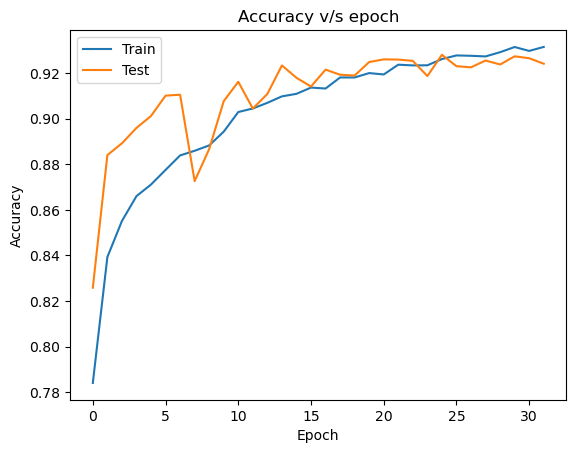

In [ ]:
plt.title("Accuracy v/s epoch") #train and test accuracy plot. test has a few ups and downs, but the model stabilised until early stopping's patience ran out.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
example of the cnn output showing probabilities:
[1.17587717e-10 2.61747720e-12 2.63564257e-12 2.44508754e-11
 5.52046187e-11 9.99940515e-01 1.36286316e-10 5.82900866e-05
 1.03386055e-08 1.21335290e-06]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1223
           1       0.98      0.99      0.99      1212
           2       0.93      0.86      0.89      1181
           3       0.94      0.91      0.93      1170
           4       0.87      0.90      0.88      1183
           5       0.99      0.99      0.99      1222
           6       0.75      0.81      0.78      1149
           7       0.96      0.98      0.97      1235
           8       0.99      1.00      0.99      1230
           9       0.98      0.96      0.97      1195

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     1200

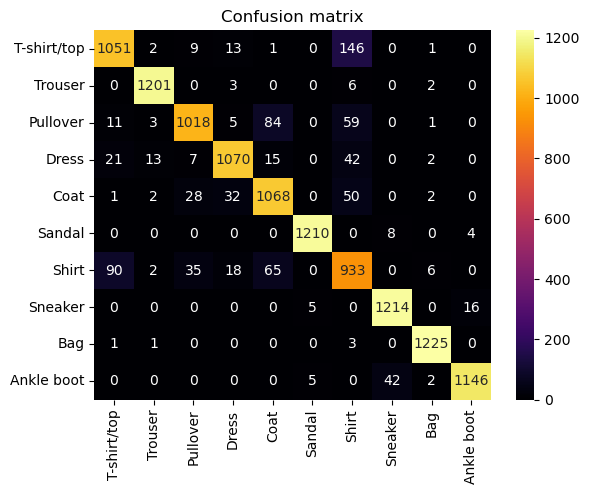

In [ ]:
probabalistics = cnn.predict(xtest)

print("example of the cnn output showing probabilities:")
print(probabalistics[0]) #softmax output for probability values of classes

predictions = np.argmax(probabalistics, axis=1) #converts row into single value of highest prob. index = class ID
real_labels = np.argmax(ytest, axis=1) #same here, except only vector of 0s and 1s

indexed_items = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(classification_report(real_labels, predictions)) #classification report and confusion matrix

cm = confusion_matrix(real_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap="inferno")
plt.title("Confusion matrix")
plt.xticks(np.arange(10) + 0.5, indexed_items, rotation=90)
plt.yticks(np.arange(10) + 0.5, indexed_items, rotation=0)
plt.show()

Text(0.5, 1.0, 'Misclassification report')

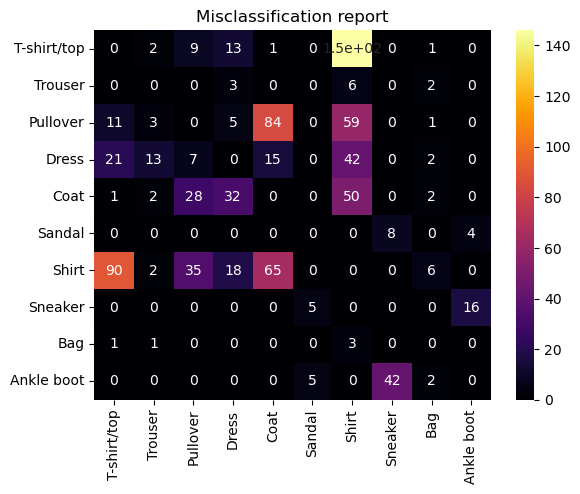

In [ ]:
np.fill_diagonal(cm, 0) #removing all correctly classified examples - in the diagonal
sns.heatmap(cm, annot=True, cmap="inferno")
plt.xticks(np.arange(10) + 0.5, indexed_items, rotation=90)
plt.yticks(np.arange(10) + 0.5, indexed_items, rotation=0)
plt.title("Misclassification report")

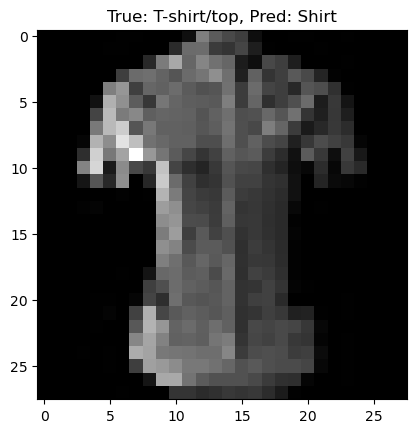

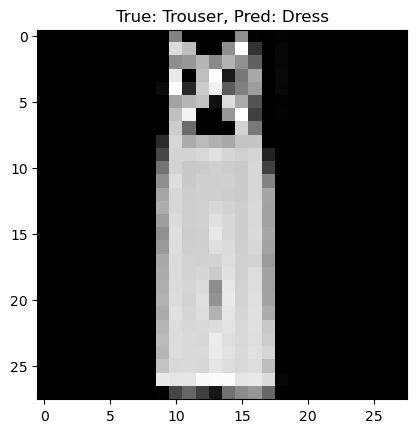

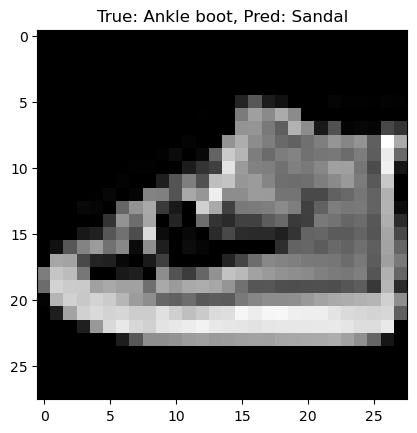

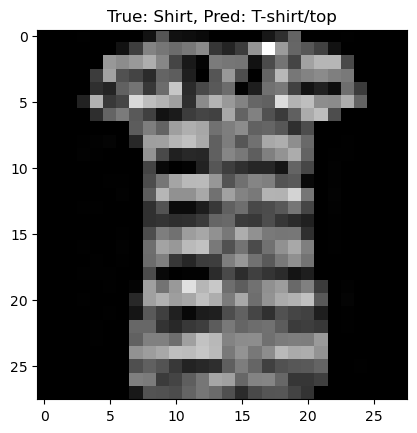

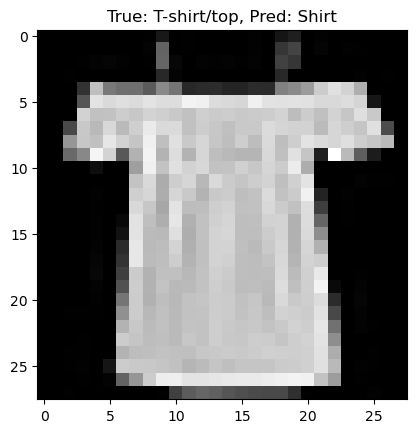

In [ ]:
errors = np.where(predictions != real_labels)[0] #displaying the first 5 images where the model misclassified.
for i in errors[:5]:
    plt.imshow(xtest[i], cmap='gray')
    plt.title(f"True: {indexed_items[real_labels[i]]}, Pred: {indexed_items[predictions[i]]}")
    plt.show()
    
#the classes tshirt and shirt are very similar. the model is expected to make some errors here. similar with ankle boots and sandals, and pullovers and coats.

### Classification Scores and ROC curve (1 v/s others)

In [45]:
print(f"Matthew's Correlation Coefficient : {matthews_corrcoef(real_labels, predictions)}")
print(f"Accuracy : {accuracy_score(real_labels, predictions)}")
print(f"f1 score : {f1_score(real_labels, predictions, average='weighted')}")
print(f"Log loss : {log_loss(real_labels, probabalistics)}")
print(f"Recall : {recall_score(real_labels, predictions, average='weighted')}")
print(f"Precision : {precision_score(real_labels, predictions, average='weighted')}")

Matthew's Correlation Coefficient : 0.920077699618256
Accuracy : 0.928
f1 score : 0.9283622104694984
Log loss : 0.19972132900106024
Recall : 0.928
Precision : 0.9294166607212725


Note how tshirts and shirts, and coats and pullovers - have the highest FPR and lowest AUC. This is simply due to them being very similar to each other with the given information.

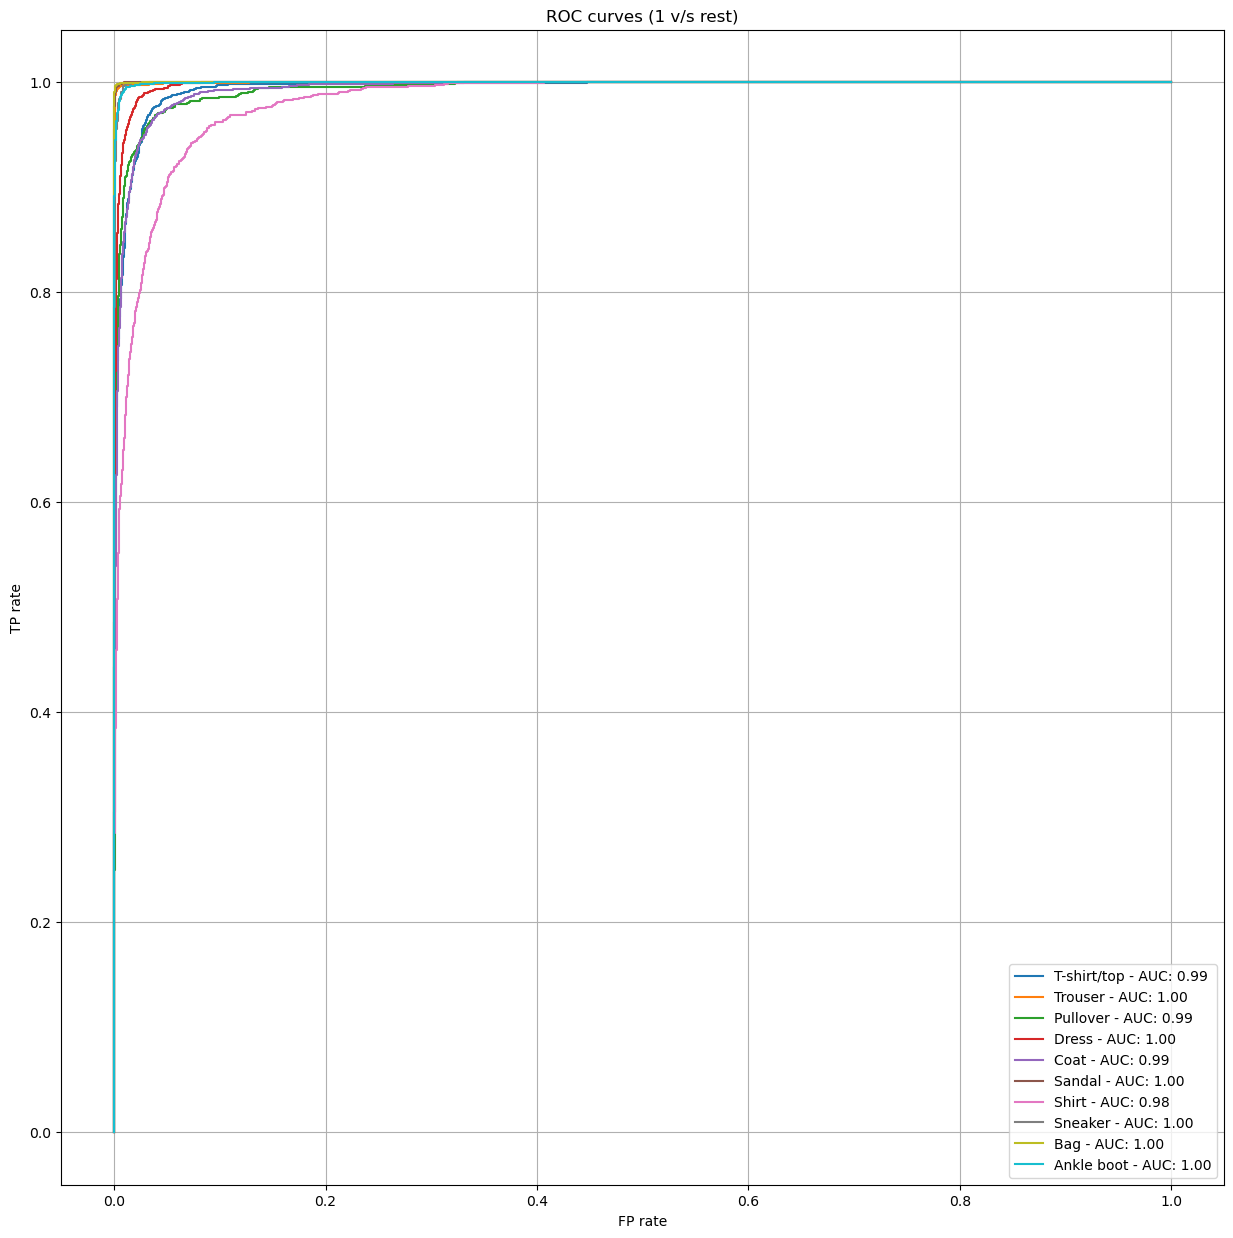

In [ ]:
real_bin = label_binarize(real_labels, classes=np.arange(10))

plt.figure(figsize=(15, 15))

for i in range(10):
    
    false_p_rate, true_p_rate, thresholds = roc_curve(real_bin[:, i], probabalistics[:, i])
    
    roc_auc = auc(false_p_rate, true_p_rate) #higher area under curve - straighter the lines - lesser the FPR
    
    plt.plot(false_p_rate, true_p_rate, label=f"{indexed_items[i]} - AUC: {roc_auc:.2f}")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (1 v/s rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Conclusion

The model indeed delivers exceptional performace - confident with robust, strong and generalised features.

Despite the augmentation, class similarity and lack of resolution, the model has achieved breathtaking accuracies touching 94%, and high scores across all classification metrics.

Thus, this model has solved the problem posed by the dataset.